<a href="https://colab.research.google.com/github/GeorgeTsio/PyTorch_toy_problems/blob/main/multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Load the libraries and set device agnostic code

In [61]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

### 1. Create the dataset and visualize it

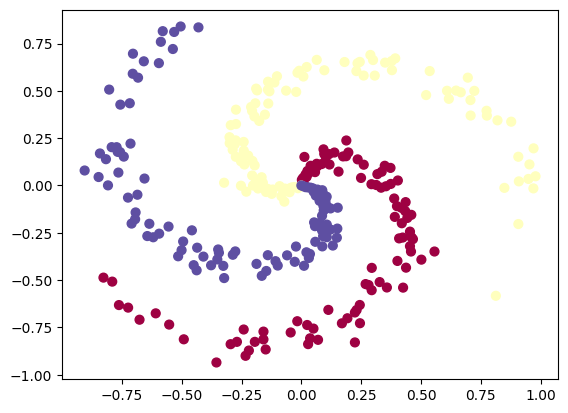

In [62]:
# Creating a spiral dataset from CS231n
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

### 2. Turn data into tensors and split to train and test dataset

In [63]:
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Length of X_train: {len(X_train)} and y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)} and y_test: {len(y_test)}")

Length of X_train: 240 and y_train: 240
Length of X_test: 60 and y_test: 60


### 3. Build a model by subclassing  nn.Module

In [64]:
class MultiClassClassification(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
    super().__init__()
    self.linear_layer_stack_1 = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units)
    )

  def forward(self, x):
    return self.linear_layer_stack_1(x)

In [65]:
# Create an instance of that model
model_0 = MultiClassClassification(in_features = 2,
                                   hidden_units = 10,
                                   out_features =  3).to(device)
model_0

MultiClassClassification(
  (linear_layer_stack_1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)

### 4. Setup a loss function, an accuracy function and an optimizer

In [66]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.02)

# Accuracy function
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device

### 5. Build a training loop for the model

In [67]:
epochs = 1000


# Send data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):

  ### Training
  model_0.train()

  #1.   Forward pass
  y_logits = model_0(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_preds, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_preds, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 2.19 Acc: 0.37 | Test loss: 2.10 Test acc: 0.37
Epoch: 100 | Loss: 0.28 Acc: 0.90 | Test loss: 0.24 Test acc: 0.93
Epoch: 200 | Loss: 0.07 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 300 | Loss: 0.04 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


### 6. Let's visualize how good our model fit the data

In [68]:
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

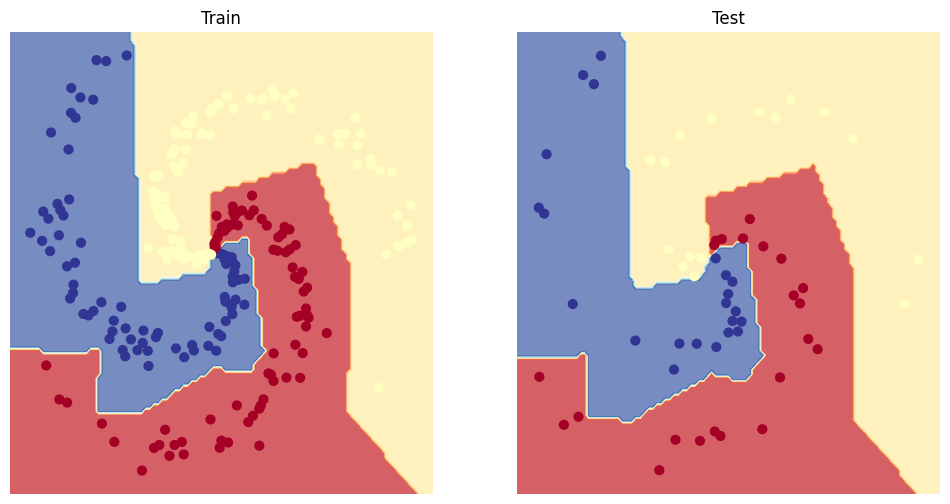

In [69]:
# Plot decision boundaries for test and training sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.axis(False)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.axis(False);